## Importar librerías

In [1]:
import janitor
import nhanes.load
import numpy as np
import pandas as pd
import missingno

## Importar funciones personalizadas

In [2]:
%run ../context/0-pandas-missing-extension.ipynb

c:\Users\usuario\Desktop\DS\14-datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


## Cargar los datos de NHANES

In [3]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year='2017-2018')
    .clean_names(
        case_type = 'snake'
    )
)

nhanes_raw_df.shape

(8366, 197)

## Procesar los datos de NHANES

In [4]:
nhanes_df = (
    # Seleccionando algunas columnas
    nhanes_raw_df.select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    # Renombrando las columnas con un diccionario
    .rename_columns(
        {
            'age_in_years_at_screening': 'age',
            'current_selfreported_height_inches': 'height',
            'current_selfreported_weight_pounds': 'weight',
            'doctor_told_you_have_diabetes': 'diabetes',
            '60_sec_pulse30_sec_pulse2': 'pulse',
            'total_cholesterol_mgdl': 'total_cholesterol'
        }
    )
    # Reemplazar los valores 'nulos' al formato nulo con 'np.nan'
    .replace(
        {
            # Columna altura
            'height': {
                9999: np.nan,
                7777: np.nan
            },
            # Columna peso
            'weight': {
                9999: np.nan,
                7777: np.nan
            },
            # Columna donde el doctor dice que el paciente tiene diabetes 0:No tiene, 1:Si tiene, no sé sabe: Boderline --> np.nan 
            'diabetes': {
                'Borderline': np.nan
            }
        }
    )
    # Las columnas con valores faltantes son: height, weight, general_health..., total_cholesterol, pulse and diabetes
    .missing.sort_variables_by_missingness()
    # Eliminar los valores nulos de la columna diabetes (se debe justificar)
    .dropna(
        subset = ['diabetes'],
        how = 'any'
    )
    # Cambiar el formato de la columna diabetes de 'objeto' a 'entero'
    .transform_column(
        column_name = 'diabetes',
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

nhanes_df

c:\Users\usuario\Desktop\DS\14-datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [5]:
nhanes_df.shape

(8187, 8)

## Visualizar los valores faltantes

<Axes: >

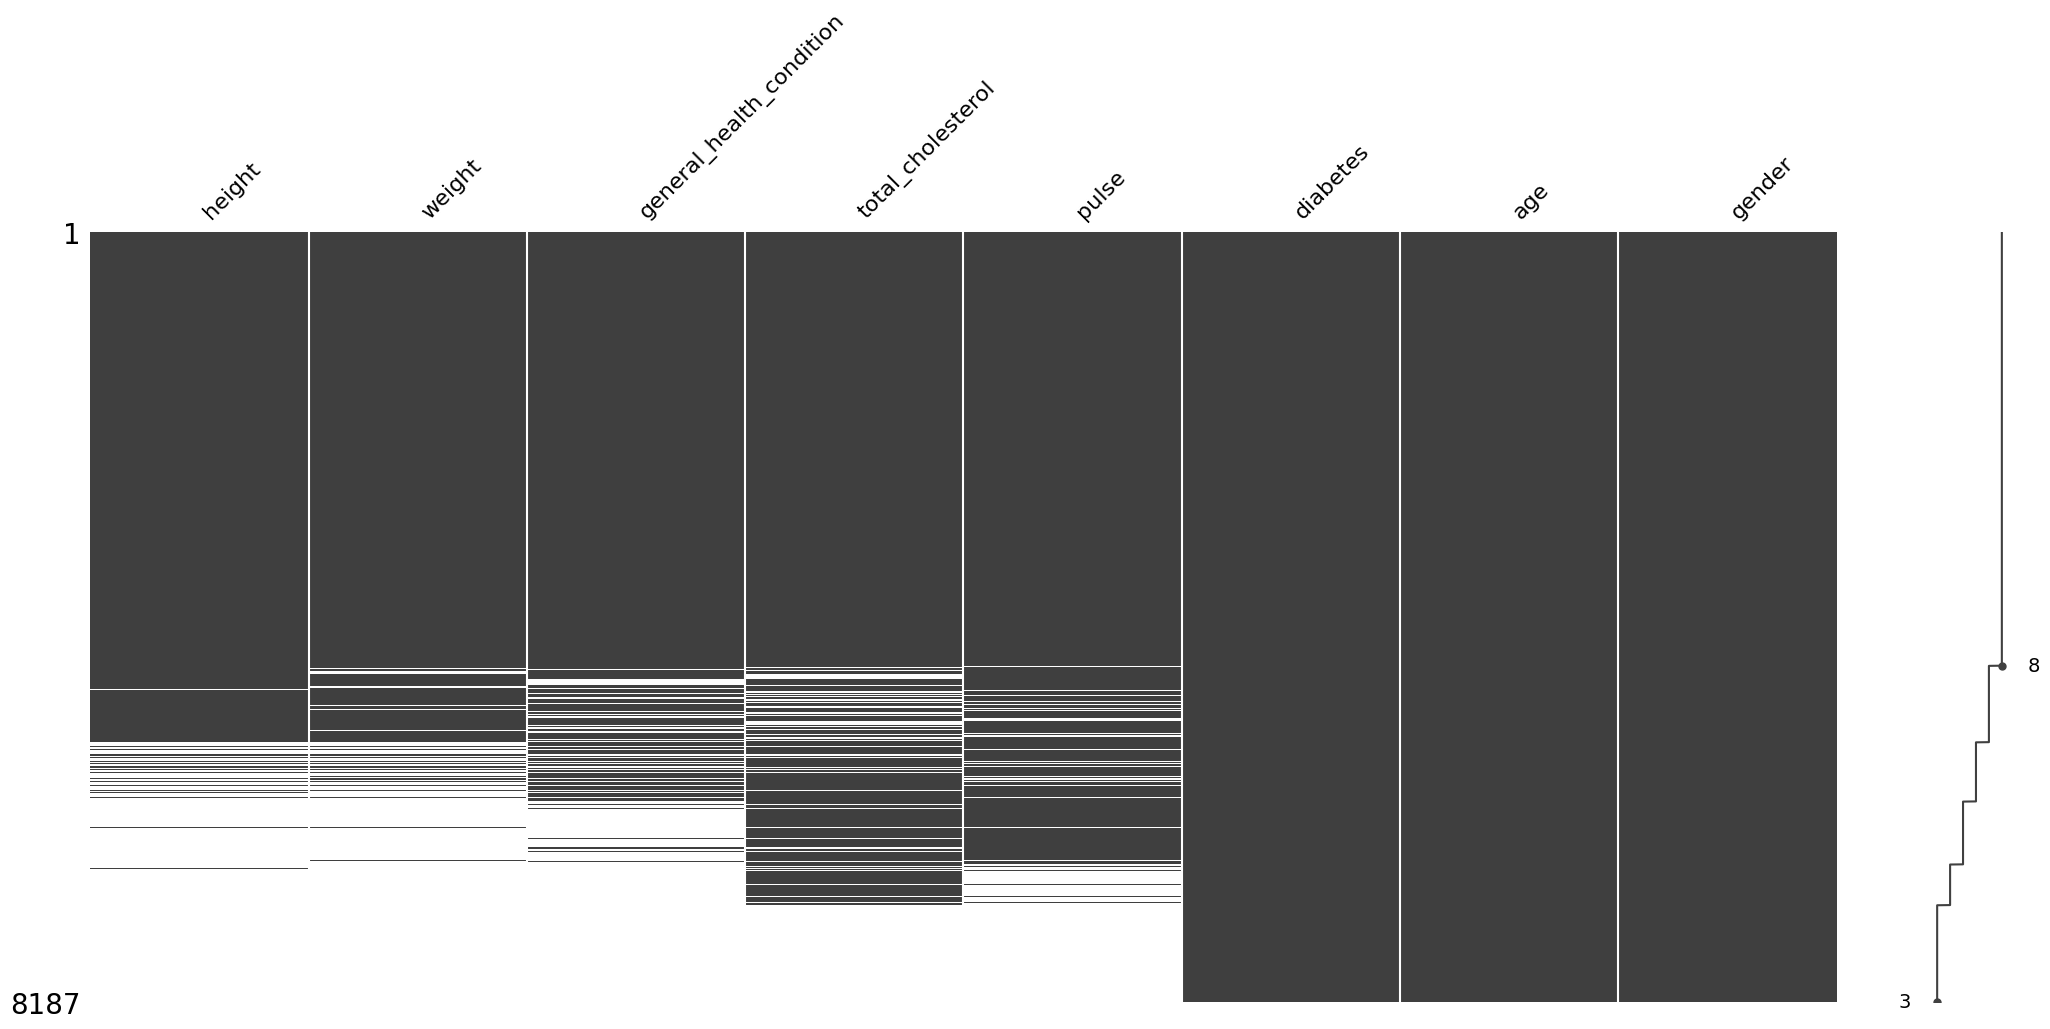

In [6]:
(
    # DatFrame
    nhanes_df
    # Organizar variables por faltantes (tienen variables)
    .missing.sort_variables_by_missingness()
    # Matriz de faltantes
    .pipe(missingno.matrix, sort='descending')
)

c:\Users\usuario\Desktop\DS\14-datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
c:\Users\usuario\Desktop\DS\14-datos-faltantes-detecccion-y-exploracion\project\.env\Lib\site-packages\upsetplot\plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

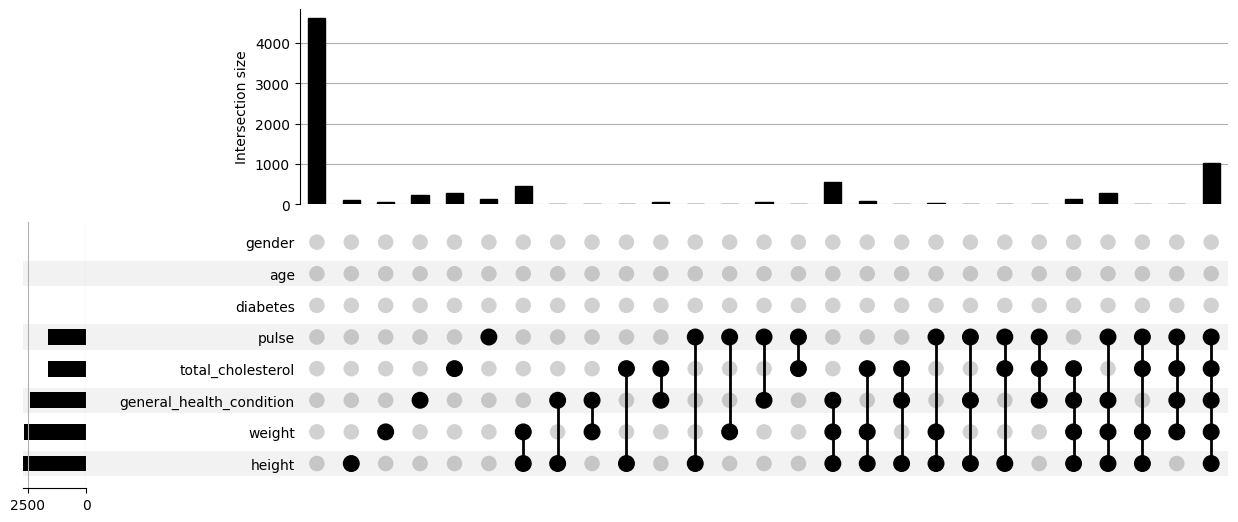

In [7]:
(
    # DataFrame
    nhanes_df
    # Organizar variables por faltantes
    .missing.sort_variables_by_missingness()
    # Grafico
    .missing.missing_upsetplot()
)

<Axes: >

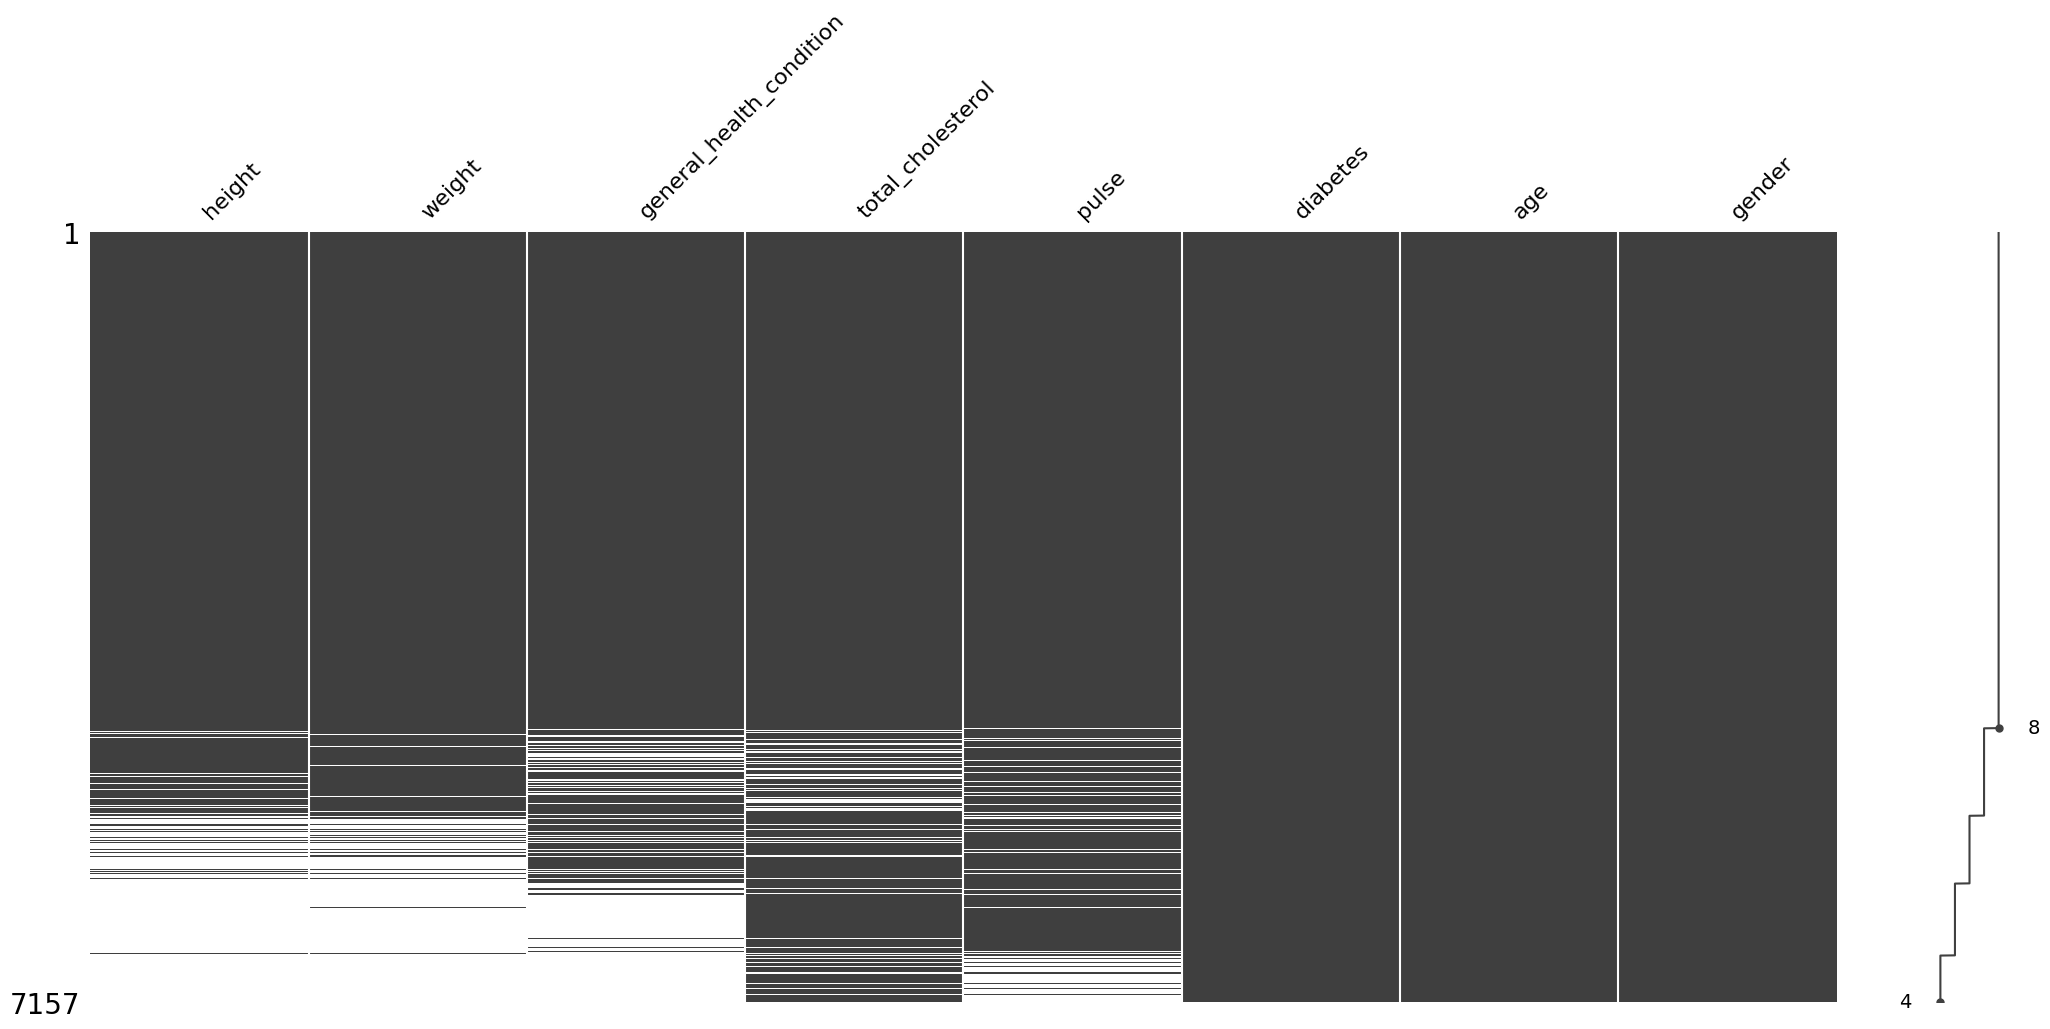

In [8]:
(
    # DataFrame
    nhanes_df
    # Metodo dropna
    .dropna(
        # Columnas consideradas para la eliminaciòn de datos faltantes
        subset = ['pulse', 'total_cholesterol', 'general_health_condition', 'weight', 'height'],
        # Parametro, solo si los varaibles faltantes estan en estas 5 columnas, se elimina
        how = 'all'
    )
    # Ordenar por faltantes
    .missing.sort_variables_by_missingness()
    # Visualización 
    .pipe(lambda df: missingno.matrix(df, sort='descending'))
)

## Eliminar valores faltantes

In [9]:
# Guardar el DF
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ['pulse', 'total_cholesterol', 'general_health_condition', 'weight', 'height'],
        how = 'all'
    )
)

nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [10]:
nhanes_df.shape

(7157, 8)

In [11]:
# Se perdieron 1030 filas del DF original
8187-7157

1030